In [13]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np

**Задача**

Требуется: предложить модель, сегментирующую человека на фотографии.

Вход: фотография 320x240x3.
Выход: маска человека 320x240.
Метрика: Dice coefficient.

**Загрузим данные, посмотрим на картинки и маски**

In [55]:
def load_data(path: str = "./../data"):
    
    train_paths = sorted(glob(os.path.join(path, "train/*.jpg")))
    train_masks_path = sorted(glob(os.path.join(path, "train_mask/*.png")))
    
    val_paths = sorted(glob(os.path.join(path, "valid/*.jpg")))
    val_masks_path = sorted(glob(os.path.join(path, "valid_mask/*.png")))
    
    test_paths = sorted(glob(os.path.join(path, "test/*.jpg")))

    train_images = np.array([
        cv2.cvtColor(cv2.imread(x), cv2.COLOR_RGB2BGR) for x in train_paths
    ])
    train_masks = np.array([cv2.imread(x, 0) for x in train_masks_path])
    
    val_images = np.array([
        cv2.cvtColor(cv2.imread(x), cv2.COLOR_RGB2BGR) for x in val_paths
    ])
    val_masks = np.array([cv2.imread(x, 0) for x in val_masks_path])
    
    test_images = np.array([
        cv2.cvtColor(cv2.imread(x), cv2.COLOR_RGB2BGR) for x in test_paths
    ])
    
    return train_images, train_masks, val_images, val_masks, test_images

In [56]:
def plot_images_with_masks(images: np.ndarray, masks: np.ndarray):

    f, ax = plt.subplots(3, 6, figsize=(12, 8))
    
    for i in range(3):
        for j in range(3):
            ax[i, 2 * j].imshow(images[3 * i + j])
            ax[i, 2 * j + 1].imshow(masks[3 * i + j])
    
    f.tight_layout()

In [118]:
def plot_color_hist(train_images, val_images, test_images, channel=0):
    
    channels = {0: "red", 1: "green", 2: "blue"}
    
    plt.figure(figsize=(15, 8))
    _ = plt.hist(
        train_images[:, :, :, channel].ravel(), 
        bins=256, 
        color='red', 
        alpha=0.5, 
        normed=True
    )
    _ = plt.hist(
        val_images[:, :, :, channel].ravel(), 
        bins=256, 
        color='green', 
        alpha=0.5, 
        normed=True
    )
    _ = plt.hist(
        test_images[:, :, :, channel].ravel(), 
        bins=256, 
        color='blue', 
        alpha=0.5, 
        normed=True
    )

    plt.xlabel('Intensity Value')
    plt.ylabel('Count')
    plt.legend([
        f"{channels[channel]}_channel_train", 
        f"{channels[channel]}_channel_val", 
        f"{channels[channel]}_channel_test", 
    ])

In [57]:
train_images, train_masks, val_images, val_masks, test_images = load_data()

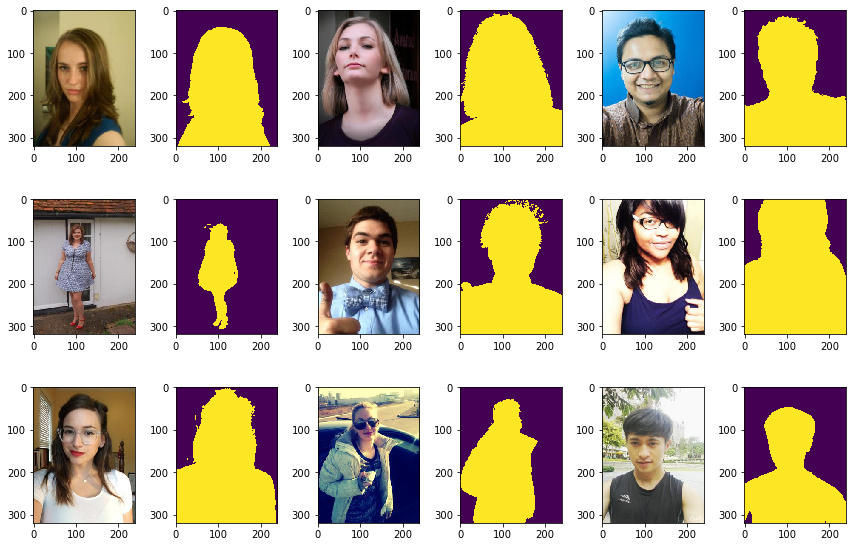

In [59]:
train_sample = np.random.randint(0, len(train_images), 9)
plot_images_with_masks(train_images[train_sample], train_masks[train_sample])

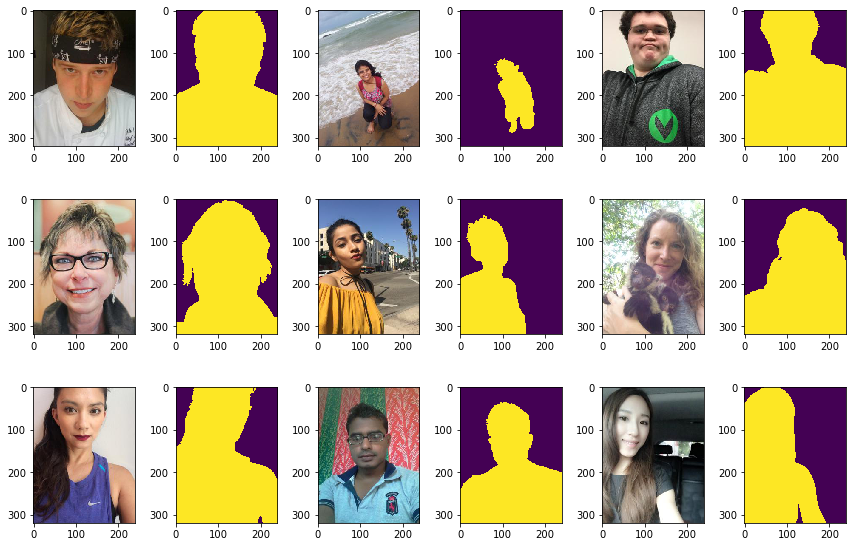

In [60]:
val_sample = np.random.randint(0, len(val_images), 9)
plot_images_with_masks(val_images[val_sample], val_masks[val_sample])

Видим, что на изображениях люди могут быть под разным углом, изображения имеют разное освещение. Учтем это и используем аугментации во время обучения модели

**Посмотрим на распределения размеров масок на трейне и валидации**

In [61]:
train_mask_coverage = [(x != 0).sum() / (x.shape[0] * x.shape[1]) for x in train_masks]
val_mask_coverage = [(x != 0).sum() / (x.shape[0] * x.shape[1]) for x in val_masks]

(array([0.43373829, 0.52048595, 0.78072892, 0.69398126, 1.47471018,
        2.60242973, 2.77592504, 1.99519612, 0.86747658, 0.43373829]),
 array([0.12804688, 0.20754818, 0.28704948, 0.36655078, 0.44605208,
        0.52555339, 0.60505469, 0.68455599, 0.76405729, 0.84355859,
        0.9230599 ]),
 <a list of 10 Patch objects>)

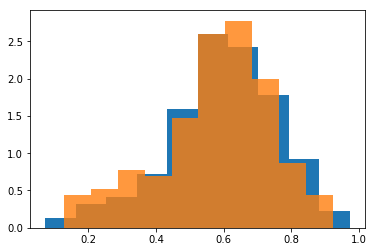

In [62]:
plt.hist(train_mask_coverage, normed=True)
plt.hist(val_mask_coverage, normed=True, alpha=0.8)

Распределения совпадают

**Рассмотрим распредления цветов**

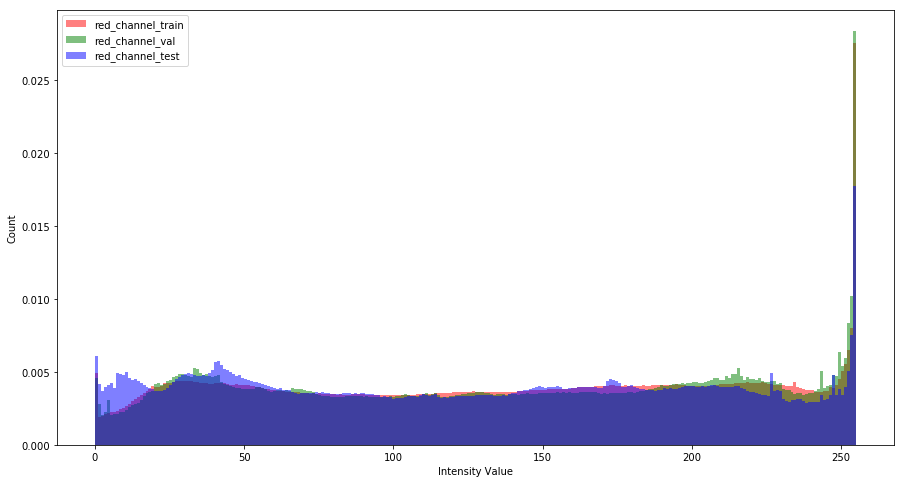

In [119]:
plot_color_hist(train_images, val_images, test_images, channel=0)

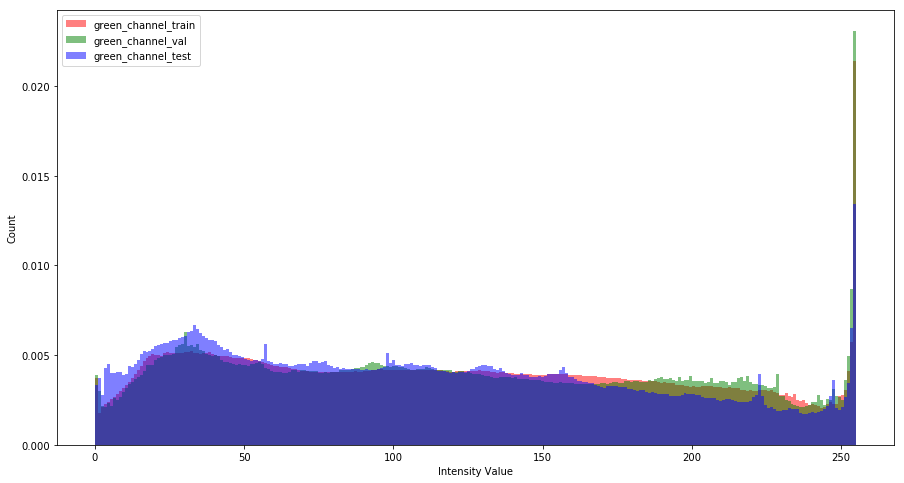

In [120]:
plot_color_hist(train_images, val_images, test_images, channel=1)

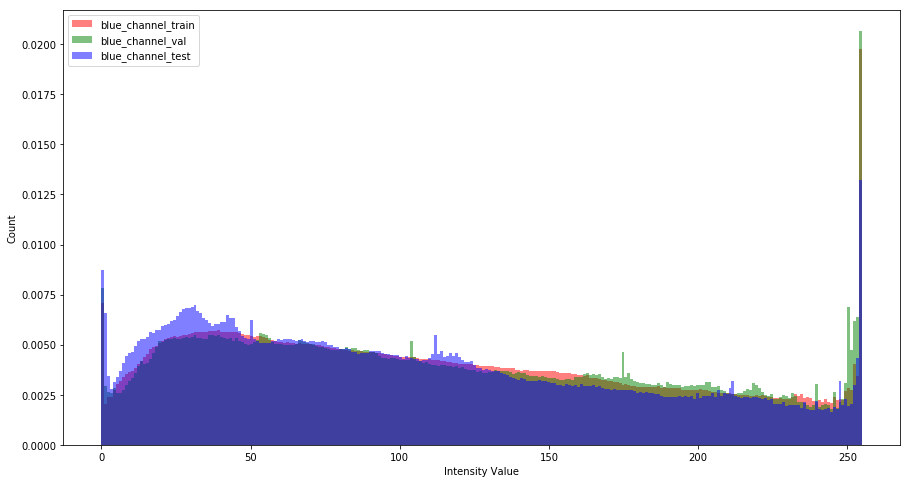

In [121]:
plot_color_hist(train_images, val_images, test_images, channel=2)

В целом распределения на тесте не сильно отличаются от распределений на трейне и валидации